# 5. CNN-LSTM

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Pseudo-Lab/Tutorial-Book-en/blob/master/book/chapters/en/time-series/Ch5-CNN-LSTM.ipynb)

In the previous chapter, we predicted COVID-19 cases in South Korea by using the LSTM model. LSTM was first introduced by [Hochreiter &amp; Schmidhuber (1997)](http://www.bioinf.jku.at/publications/older/2604.pdf), and has been developed continuously since.

In this chapter, we will experiment with a different method in order to enhance model performance. There are several ways to enhance model performance, such as changing batch size and number of epochs, dataset curating, adjusting the ratio of the training, validation, and test datasets, changing loss functions and model architectures, and so on. In this chapter, we will improve model performance by changing the model architecture. More specifically, we will see if the CNN-LSTM model can predict COVID-19 cases in South Korea better than the LSTM model.

Firstly, we will load the libraries we will need for this chapter. We will use the basic libraries `torch`, `numpy`, and `pandas`, along with `tqdm` which shows progress status, and `pylab` and `matplotlib`, which are visualization libraries.

In [ ]:
import torch
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.preprocessing import MinMaxScaler
from pandas.plotting import register_matplotlib_converters
from torch import nn, optim

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)
rcParams['figure.figsize'] = 14, 10
register_matplotlib_converters()
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

## 5.1 Download Datasets and Pre-Processing


We will load the cumulative South Korean COVID-19 cases dataset for the modeling practice. We will use the code we deployed in chapter 2.1. 

In [ ]:
!git clone https://github.com/Pseudo-Lab/Tutorial-Book-Utils
!python Tutorial-Book-Utils/PL_data_loader.py --data COVIDTimeSeries
!unzip -q COVIDTimeSeries.zip

Cloning into 'Tutorial-Book-Utils'...
remote: Enumerating objects: 24, done.
remote: Counting objects: 100% (24/24), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 24 (delta 6), reused 14 (delta 3), pack-reused 0
Unpacking objects: 100% (24/24), done.
COVIDTimeSeries.zip is done!


After loading the COVID-19 dataset through the `pandas` library, we will perform data pre-processing, using the same method we used in chapter 3. The time period for the data will be from January 22, 2020 to December 18, 2020.

In [ ]:
# Load the cumulative COVID-19 cases for South Korea.
confirmed = pd.read_csv('time_series_covid19_confirmed_global.csv')
confirmed[confirmed['Country/Region']=='Korea, South']
korea = confirmed[confirmed['Country/Region']=='Korea, South'].iloc[:,4:].T
korea.index = pd.to_datetime(korea.index)
daily_cases = korea.diff().fillna(korea.iloc[0]).astype('int')


def create_sequences(data, seq_length):
    xs = []
    ys = []
    for i in range(len(data)-seq_length):
        x = data.iloc[i:(i+seq_length)]
        y = data.iloc[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

# Data transformation for supervised learning data.
seq_length = 5
X, y = create_sequences(daily_cases, seq_length)

# Dividing the dataset into traning, validation, and test sets.
train_size = int(327 * 0.8)
X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:train_size+33], y[train_size:train_size+33]
X_test, y_test = X[train_size+33:], y[train_size+33:]

MIN = X_train.min()
MAX = X_train.max()

def MinMaxScale(array, min, max):

    return (array - min) / (max - min)

# MinMax scaling
X_train = MinMaxScale(X_train, MIN, MAX)
y_train = MinMaxScale(y_train, MIN, MAX)
X_val = MinMaxScale(X_val, MIN, MAX)
y_val = MinMaxScale(y_val, MIN, MAX)
X_test = MinMaxScale(X_test, MIN, MAX)
y_test = MinMaxScale(y_test, MIN, MAX)

# Tensor transformation
def make_Tensor(array):
    return torch.from_numpy(array).float()

X_train = make_Tensor(X_train)
y_train = make_Tensor(y_train)
X_val = make_Tensor(X_val)
y_val = make_Tensor(y_val)
X_test = make_Tensor(X_test)
y_test = make_Tensor(y_test)

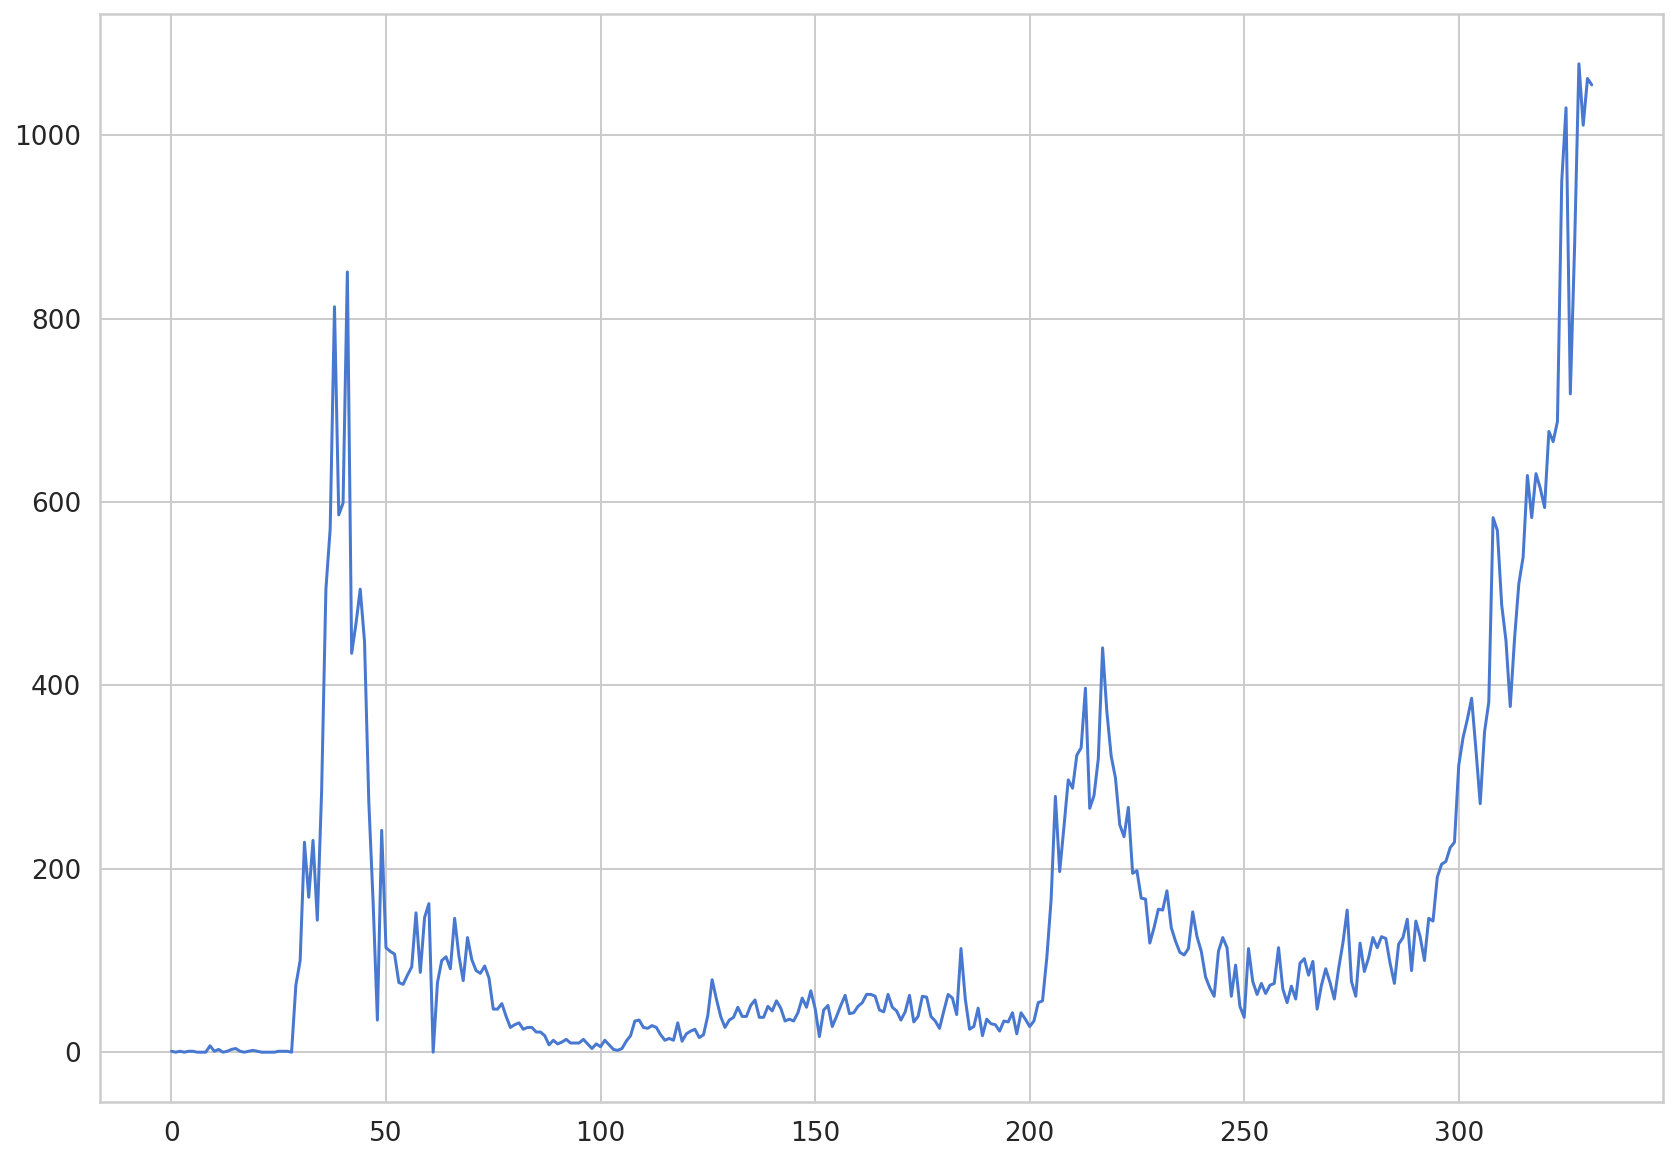

In [ ]:
plt.plot(daily_cases.values)

## 5.2 Defining the CNN-LSTM Model

### 5.2.1 1D CNN (1 Dimensional Convolution Neural Network) / Conv1D

In chapter 4, we predicted COVID-19 cases using the LSTM model. In this chapter, we will predict COVID-19 cases by adding a CNN layer to the LSTM model.

CNN models can process 1D, 2D, or 3D inputs. In general, CNNs assume inputs are 2D unless we specify otherwise.

<br>

![그림 5-1](https://github.com/Pseudo-Lab/Tutorial-Book/blob/master/book/pics/TS-ch5img01.png?raw=true)


- Figure 5-1 Visualization of Times Series Data (Source: Understanding 1D and 3D Convolution Neural Network | Keras)

Figure 5-1 is a one-dimensional illustration visualizing the kernel movements of a CNN. As time passes, the kernel moves to the right. When dealing with time series data, a 1D CNN is appropriate. We can extract local features between variables if we use a 1D CNN.

### 5.2.2 Test with 1D CNN

![그림 5-2](https://github.com/Pseudo-Lab/Tutorial-Book/blob/master/book/pics/TS-ch5img02.png?raw=true) ![그림 5-3](https://github.com/Pseudo-Lab/Tutorial-Book/blob/master/book/pics/TS-ch5img03.png?raw=true)

- Figures 5-2 &amp; 5-3 1D CNN Visualization

Figures 5-2 and 5-3 are the visualizations of 1D CNN architectures. Between Figure 5-2 and Figure 5-3, you can see the kernel moves one step when `stride` is 1. Now we will examine a 1D CNN through simple code.

Firstly, define and save a 1D CNN layer in `c`. Like in Figures 5-2 and 5-3, we will set `in_channels`=1, `out_channels`=1, `kernel_size`=2, and `stride`=1. After that, define the `input` variables, then apply them into `c` to calculate the predicted values.


In [ ]:
c = nn.Conv1d(in_channels=1, out_channels=1, kernel_size=2, stride=1)
input = torch.Tensor([[[1,2,3,4,5]]])
output = c(input)
output

tensor([[[-0.3875, -0.8842, -1.3808, -1.8774]]], grad_fn=<SqueezeBackward1>)

The 5 input examples generated 4 output values after passing through the 1D CNN with `kernel_size`=2. Next, we will find how the output values were generated. Let's view the values of weight and bias saved in `c`, first.

In [ ]:
for param in c.parameters():
    print(param)

Parameter containing:
tensor([[[-0.1021, -0.3946]]], requires_grad=True)
Parameter containing:
tensor([0.5037], requires_grad=True)


The first values are the weights. The `kernel_size` is 2, so there are two values for weight. The next value is the bias value. In each 1D CNN layer, there is one bias value. We will save each value under `w1`, `w2`, and `b` respectively.

In [ ]:
w_list = []
for param in c.parameters():
    w_list.append(param)

w = w_list[0]
b = w_list[1]

w1 = w[0][0][0]
w2 = w[0][0][1]

print(w1)
print(w2)
print(b)

tensor(-0.1021, grad_fn=<SelectBackward>)
tensor(-0.3946, grad_fn=<SelectBackward>)
Parameter containing:
tensor([0.5037], requires_grad=True)


Through indexing, we saved the weight values under `w1`, `w2`, and `b`. Applying the math formula in Figures 5-2 and 5-3 used for the calculation of $y1$ and $y2$, we can calculate the `output` of the 1D CNN. The calculated output, when the 1D CNN filter passes 3 and 4, is shown in the following: 

In [ ]:
w1 * 3 + w2 * 4 + b

tensor([-1.3808], grad_fn=<AddBackward0>)

This result is the same as the third value of the `output`. The rest of the values are calculated in this way. 

In [ ]:
output

tensor([[[-0.3875, -0.8842, -1.3808, -1.8774]]], grad_fn=<SqueezeBackward1>)

## 5.3 Build the CNN-LSTM Model

We will build the CNN-LSTM model now. The biggest difference from the LSTM model we built in chapter 4 is that we are adding the 1D CNN layer in this model. When viewing the code below, we can see that the 1D CNN layer was added to `CovidPredictor` through `nn.Conv1d`.

In [ ]:
class CovidPredictor(nn.Module):
    def __init__(self, n_features, n_hidden, seq_len, n_layers):
        super(CovidPredictor, self).__init__()
        self.n_hidden = n_hidden
        self.seq_len = seq_len
        self.n_layers = n_layers
        self.c1 = nn.Conv1d(in_channels=1, out_channels=1, kernel_size = 2, stride = 1) # Add a 1D CNN layer
        self.lstm = nn.LSTM(
            input_size=n_features,
            hidden_size=n_hidden,
            num_layers=n_layers
        )
        self.linear = nn.Linear(in_features=n_hidden, out_features=1)
    def reset_hidden_state(self):
        self.hidden = (
            torch.zeros(self.n_layers, self.seq_len-1, self.n_hidden),
            torch.zeros(self.n_layers, self.seq_len-1, self.n_hidden)
        )
    def forward(self, sequences):
        sequences = self.c1(sequences.view(len(sequences), 1, -1))
        lstm_out, self.hidden = self.lstm(
            sequences.view(len(sequences), self.seq_len-1, -1),
            self.hidden
        )
        last_time_step = lstm_out.view(self.seq_len-1, len(sequences), self.n_hidden)[-1]
        y_pred = self.linear(last_time_step)
        return y_pred

## 5.4 Train the CNN-LSTM Model


We will train the CNN-LSTM model using the `Adam` function we already built in chapter 4. We set `Adam` as the optimizer, with a learning rate of `0.001` and the loss function as `MAE (Mean Absolute Error)`.

In [ ]:
def train_model(model, train_data, train_labels, val_data=None, val_labels=None, num_epochs=100, verbose = 10, patience = 10):
    loss_fn = torch.nn.L1Loss() #
    optimiser = torch.optim.Adam(model.parameters(), lr=0.001)
    train_hist = []
    val_hist = []
    for t in range(num_epochs):

        epoch_loss = 0

        for idx, seq in enumerate(train_data): # hidden state needs to be reset after every sample

            model.reset_hidden_state()

            # train loss
            seq = torch.unsqueeze(seq, 0)
            y_pred = model(seq)
            loss = loss_fn(y_pred[0].float(), train_labels[idx]) # calculated loss after 1 step

            # update weights
            optimiser.zero_grad()
            loss.backward()
            optimiser.step()

            epoch_loss += loss.item()

        train_hist.append(epoch_loss / len(train_data))

        if val_data is not None:

            with torch.no_grad():

                val_loss = 0

                for val_idx, val_seq in enumerate(val_data):

                    model.reset_hidden_state() # hidden state reset every sequence

                    val_seq = torch.unsqueeze(val_seq, 0)
                    y_val_pred = model(val_seq)
                    val_step_loss = loss_fn(y_val_pred[0].float(), val_labels[val_idx])

                    val_loss += val_step_loss
                
            val_hist.append(val_loss / len(val_data)) # append in val hist

            ## print loss for every `verbose` times
            if t % verbose == 0:
                print(f'Epoch {t} train loss: {epoch_loss / len(train_data)} val loss: {val_loss / len(val_data)}')

            ## check early stopping for every `patience` times
            if (t % patience == 0) & (t != 0):
                
                ## if loss increased, perform early stopping
                if val_hist[t - patience] < val_hist[t] :

                    print('\n Early Stopping')

                    break

        elif t % verbose == 0:
            print(f'Epoch {t} train loss: {epoch_loss / len(train_data)}')

            
    return model, train_hist, val_hist

In [ ]:
model = CovidPredictor(
    n_features=1,
    n_hidden=4,
    seq_len=seq_length,
    n_layers=1
)

Let's briefly view the predicted model.

In [ ]:
print(model)

CovidPredictor(
  (c1): Conv1d(1, 1, kernel_size=(2,), stride=(1,))
  (lstm): LSTM(1, 4)
  (linear): Linear(in_features=4, out_features=1, bias=True)
)


Let's train the model. 

In [ ]:
model, train_hist, val_hist = train_model(
    model,
    X_train,
    y_train,
    X_val,
    y_val,
    num_epochs=100,
    verbose=10,
    patience=50
)

Epoch 0 train loss: 0.08868540743530025 val loss: 0.04381682723760605
Epoch 10 train loss: 0.03551809817384857 val loss: 0.033296383917331696
Epoch 20 train loss: 0.033714159246412786 val loss: 0.033151865005493164
Epoch 30 train loss: 0.03314930358741047 val loss: 0.03351602330803871
Epoch 40 train loss: 0.03311298256454511 val loss: 0.03455767780542374
Epoch 50 train loss: 0.033384358255242594 val loss: 0.03596664220094681
Epoch 60 train loss: 0.03306851693218524 val loss: 0.035104189068078995
Epoch 70 train loss: 0.03264325369823853 val loss: 0.03546909987926483
Epoch 80 train loss: 0.03269847107237612 val loss: 0.035008616745471954
Epoch 90 train loss: 0.033151885962927306 val loss: 0.034998856484889984


We will examine the training and test loss through visualization.

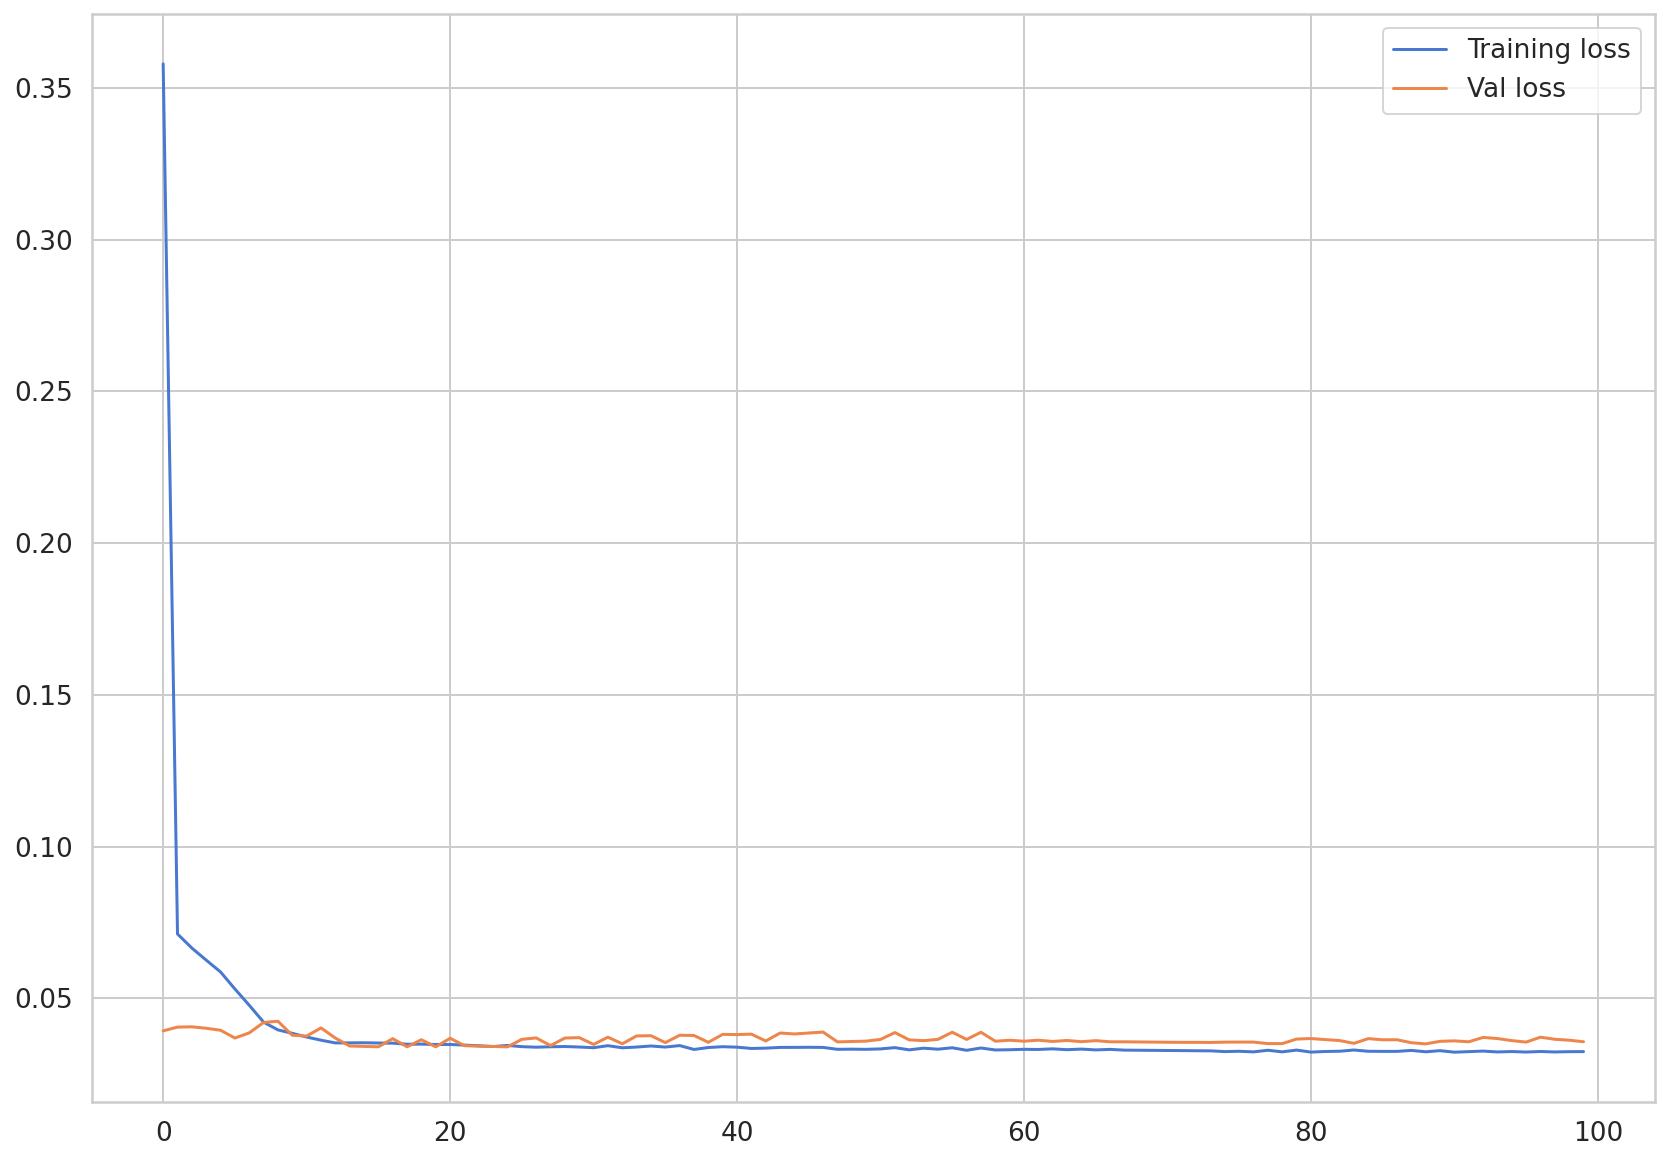

In [ ]:
plt.plot(train_hist, label="Training loss")
plt.plot(val_hist, label="Val loss")
plt.legend()

We can see that both loss values are converging. 

## 5.5 Predict Confirmed Cases

Since we are done training the CNN-LSTM model, we will predict confirmed COVID-19 cases using the trained model. When performing the prediction, `hidden_state` needs to be reset in order for the previous sequence not to influence the next step. Let's convert the input data into three dimensional shape that the model expects by using the `torch.unsqueeze` function. After that, we should extract only the scalar value from the predicted data, and then add them to the `preds` list.

In [ ]:
pred_dataset = X_test

with torch.no_grad():
    preds = []
    for _ in range(len(pred_dataset)):
        model.reset_hidden_state()
        y_test_pred = model(torch.unsqueeze(pred_dataset[_], 0))
        pred = torch.flatten(y_test_pred).item()
        preds.append(pred)

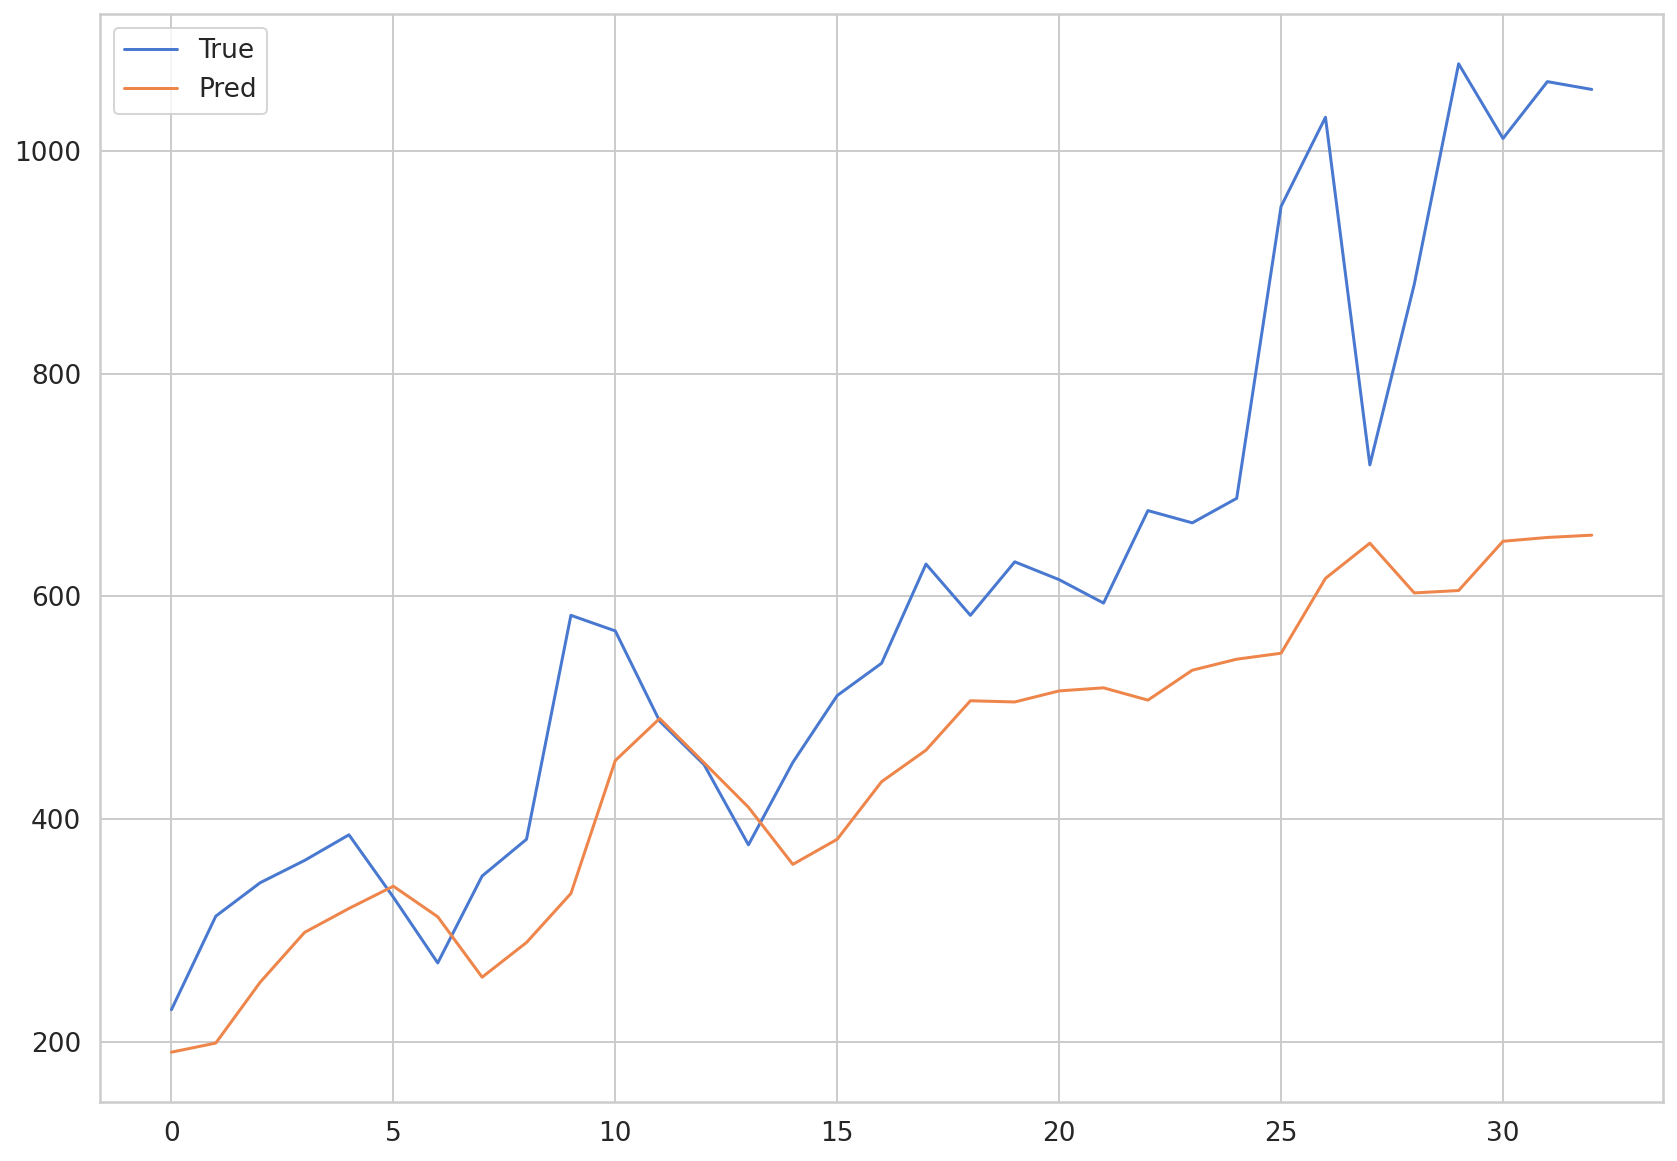

In [ ]:
plt.plot(np.array(y_test)*MAX, label = 'True')
plt.plot(np.array(preds)*MAX, label = 'Pred')
plt.legend()

In [ ]:
def MAE(true, pred):
    return np.mean(np.abs(true-pred))

In [ ]:
MAE(np.array(y_test)*MAX, np.array(preds)*MAX)

247.63305325632362

The MAE value of the LSTM model was around 250, similar to the one for the CNN-LSTM model. We can see that there is not a huge difference in terms of performance when predicting COVID-19 cases between the two models. This is because both the LSTM and CNN-LSTM models converged toward a value. In addition, it can be also due to the input data being too simple compared to the complex model architecture.

So far, we have practiced predicting COVID-19 cases with a dataset comprised of South Korean cases and the CNN-LSTM model. We have learned how to complete the following tasks in this Time Series Forecasting tutorial: the EDA of COVID-19 datasets, pre-processing the datasets, and predicting COVID-19 cases with the LSTM and CNN-LSTM models.

The accuracy of the Time Series Forecasting tasks can be low when there is not enough data given. In this Times Series Forecasting chapter, we only used confirmed case numbers from the past in order to predict future cases. Try adding other variables and features to train the deep learning model.